In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel, SliceRepModel, SliceQPModel, SliceCatModel, SliceEnsembleModel
from metal.mmtl.slicing.moe_model import MoEModel

from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, train_slice_experts
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

In [5]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [7]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=1000, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


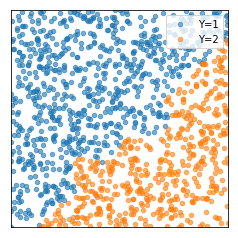

Vizualizing labelset:slice_1:pred from payload_test


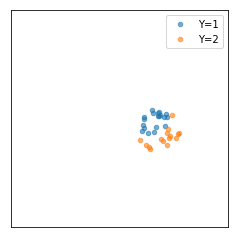

Vizualizing labelset:slice_1:ind from payload_test


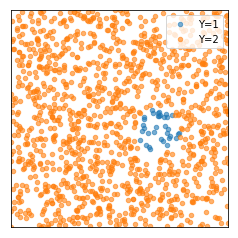

Vizualizing labelset:slice_2:pred from payload_test


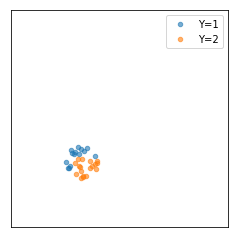

Vizualizing labelset:slice_2:ind from payload_test


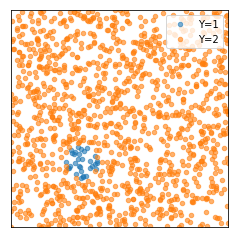

Vizualizing labelset:remainder:pred from payload_test


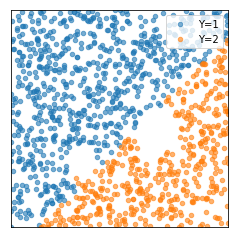

Vizualizing labelset:remainder:ind from payload_test


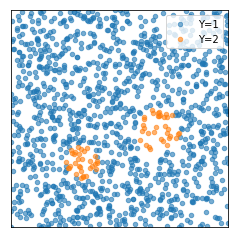

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [10]:
# all models to test to test
all_slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn}
slice_loss_multiplier = 1.0 / (2*len(all_slice_funcs))
# h_dim = 2
rep_dim = 7
h_dim = None
# h_dim = 2

model_configs = {
#     'soft_ens_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'model_class': SliceEnsembleModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'custom_neck_dim': 2*len(all_slice_funcs)
#     }, 
#     'soft_cat_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'create_preds': False,
#         'model_class': SliceCatModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'h_dim': h_dim,
#         'custom_neck_dim': (h_dim+1)*len(all_slice_funcs)
#     },   
#     'soft_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'model_class': SliceModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         }
#     },   
#     'soft_param_rep': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'create_preds': False,
#         'model_class': SliceRepModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'h_dim': h_dim
#     },
    'slice_qp_rep': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'create_preds': False,
        'create_shared_slice_pred': True,
        'model_class': SliceQPModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        },
        'h_dim': h_dim,
        'use_ind_module': True
    },
    'hard_param': {
        'slice_funcs': all_slice_funcs,
        'create_ind': False,
        'model_class': MetalModel,
        'slice_weights': {'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier}
    },
    'manual_reweighting': {
        'slice_funcs': all_slice_funcs,
        'create_ind': False,
        'slice_weights': {"slice_1": 50}, # 10x weight of slice_2, everythign else default
        'model_class': MetalModel        
    },
    'moe': {
        'slice_funcs': {},
        'create_ind': False,
        'model_class': MoEModel
    },
    'naive': {
        'slice_funcs': {},
        'model_class': MetalModel   
    }
}

In [11]:
train_kwargs = {
    "lr": 0.01, 
    "n_epochs": 2500,
    "checkpoint_best": False,
    "log_every": 5.0,
    "writer": "tensorboard", 
    "verbose": True,
    "progress_bar": False
}

In [12]:
trained_models = {}

==========Initializing + Training slice_qp_rep==========
Creating 7 tasks...
BinaryClassificationTask(name=test_task:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:pred': 'test_task:slice_1:pred', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:pred': 'test_task:slice_2:pred', 'labelset:slice_2

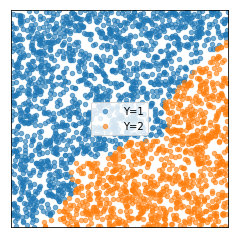

Vizualizing labelset:slice_1:pred from payload_train


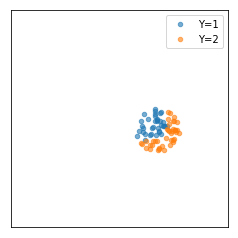

Vizualizing labelset:slice_1:ind from payload_train


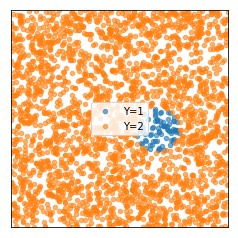

Vizualizing labelset:slice_2:pred from payload_train


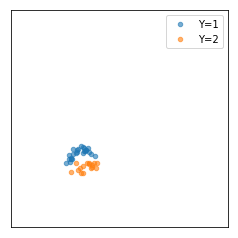

Vizualizing labelset:slice_2:ind from payload_train


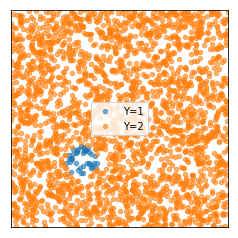

Vizualizing labelset:BASE:pred from payload_train


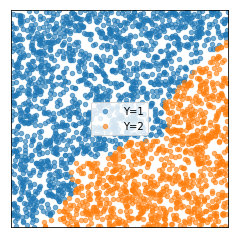

Vizualizing labelset:BASE:ind from payload_train


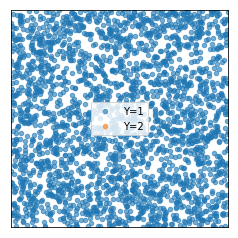


Network architecture:
SliceQPModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred): DataParallel(
      (module): MetalModuleWr

[20.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.74e-01, payload_valid/labelset_gold/f1=9.78e-01, payload_valid/labelset_gold/acc_f1=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01, payload_valid/labelset:slice_1:ind/f1=0.00e+00, payload_valid/labelset:slice_1:ind/acc_f1=4.84e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.01e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01, payload_valid/labelset:BASE:pred/f1=9.74e-01, payload_valid/labelset:BASE:pred/acc_f1=9.72e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=9.07e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_vali

[50.0 epo]: test_task:[payload_train/labelset_gold/loss=7.66e-02, payload_valid/labelset_gold/accuracy=9.78e-01, payload_valid/labelset_gold/f1=9.82e-01, payload_valid/labelset_gold/acc_f1=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.15e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01, payload_valid/labelset:slice_1:ind/f1=0.00e+00, payload_valid/labelset:slice_1:ind/acc_f1=4.84e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.18e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.85e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_vali

[80.0 epo]: test_task:[payload_train/labelset_gold/loss=7.01e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.06e-02, payload_valid/labelset:slice_1:ind/accuracy=9.71e-01, payload_valid/labelset:slice_1:ind/f1=2.17e-01, payload_valid/labelset:slice_1:ind/acc_f1=5.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.07e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_vali

[110.0 epo]: test_task:[payload_train/labelset_gold/loss=6.25e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=9.79e-03, payload_valid/labelset:slice_1:ind/accuracy=9.72e-01, payload_valid/labelset:slice_1:ind/f1=3.40e-01, payload_valid/labelset:slice_1:ind/acc_f1=6.56e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.92e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.85e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.43e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[140.0 epo]: test_task:[payload_train/labelset_gold/loss=5.19e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=9.24e-03, payload_valid/labelset:slice_1:ind/accuracy=9.76e-01, payload_valid/labelset:slice_1:ind/f1=5.71e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.74e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.06e-03, payload_valid/labelset:BASE:ind/accuracy=9.95e-01, payload_val

[170.0 epo]: test_task:[payload_train/labelset_gold/loss=4.41e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=8.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.75e-01, payload_valid/labelset:slice_1:ind/f1=5.87e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.33e-03, payload_valid/labelset:slice_2:ind/accuracy=9.77e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=6.85e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.70e-03, payload_valid/labelset:BASE:ind/accuracy=9.96e-01, payload_val

[200.0 epo]: test_task:[payload_train/labelset_gold/loss=4.12e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=7.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.76e-01, payload_valid/labelset:slice_1:ind/f1=5.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.85e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=6.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.29e-03, payload_valid/labelset:BASE:ind/accuracy=9.97e-01, payload_val

[230.0 epo]: test_task:[payload_train/labelset_gold/loss=3.93e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=7.48e-03, payload_valid/labelset:slice_1:ind/accuracy=9.75e-01, payload_valid/labelset:slice_1:ind/f1=5.87e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.89e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.18e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.47e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=6.13e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.00e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01, payload_val

[260.0 epo]: test_task:[payload_train/labelset_gold/loss=3.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.76e-01, payload_valid/labelset:slice_1:ind/f1=6.05e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.81e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.18e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.47e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.87e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=8.50e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[290.0 epo]: test_task:[payload_train/labelset_gold/loss=3.76e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.70e-03, payload_valid/labelset:slice_1:ind/accuracy=9.78e-01, payload_valid/labelset:slice_1:ind/f1=6.00e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.63e-03, payload_valid/labelset:slice_2:ind/accuracy=9.77e-01, payload_valid/labelset:slice_2:ind/f1=1.71e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.65e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.32e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[320.0 epo]: test_task:[payload_train/labelset_gold/loss=3.67e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.43e-03, payload_valid/labelset:slice_1:ind/accuracy=9.81e-01, payload_valid/labelset:slice_1:ind/f1=6.57e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.19e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.45e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.18e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.47e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.78e-01, payload_valid/labelset:BASE:pred/f1=9.81e-01, payload_valid/labelset:BASE:pred/acc_f1=9.79e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[350.0 epo]: test_task:[payload_train/labelset_gold/loss=3.57e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.13e-03, payload_valid/labelset:slice_1:ind/accuracy=9.80e-01, payload_valid/labelset:slice_1:ind/f1=6.48e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.14e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.77e-01, payload_valid/labelset:slice_2:ind/f1=1.71e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.78e-01, payload_valid/labelset:BASE:pred/f1=9.82e-01, payload_valid/labelset:BASE:pred/acc_f1=9.80e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.82e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[380.0 epo]: test_task:[payload_train/labelset_gold/loss=3.31e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.96e-03, payload_valid/labelset:slice_1:ind/accuracy=9.78e-01, payload_valid/labelset:slice_1:ind/f1=6.20e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.99e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.06e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.67e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.93e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.68e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[410.0 epo]: test_task:[payload_train/labelset_gold/loss=3.28e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.74e-03, payload_valid/labelset:slice_1:ind/accuracy=9.82e-01, payload_valid/labelset:slice_1:ind/f1=6.85e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.33e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.67e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.40e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[440.0 epo]: test_task:[payload_train/labelset_gold/loss=3.20e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.62e-03, payload_valid/labelset:slice_1:ind/accuracy=9.82e-01, payload_valid/labelset:slice_1:ind/f1=7.03e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.43e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.94e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.67e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.59e-02, payload_valid/labelset:BASE:pred/accuracy=9.79e-01, payload_valid/labelset:BASE:pred/f1=9.82e-01, payload_valid/labelset:BASE:pred/acc_f1=9.81e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.95e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[470.0 epo]: test_task:[payload_train/labelset_gold/loss=3.15e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.82e-01, payload_valid/labelset:slice_1:ind/f1=6.94e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=1.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.77e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.62e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[500.0 epo]: test_task:[payload_train/labelset_gold/loss=3.16e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.26e-03, payload_valid/labelset:slice_1:ind/accuracy=9.82e-01, payload_valid/labelset:slice_1:ind/f1=6.85e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.33e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=1.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.77e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.78e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[530.0 epo]: test_task:[payload_train/labelset_gold/loss=3.10e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.06e-03, payload_valid/labelset:slice_1:ind/accuracy=9.83e-01, payload_valid/labelset:slice_1:ind/f1=7.27e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.55e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=1.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.77e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.42e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[560.0 epo]: test_task:[payload_train/labelset_gold/loss=3.09e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.02e-03, payload_valid/labelset:slice_1:ind/accuracy=9.83e-01, payload_valid/labelset:slice_1:ind/f1=7.27e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.55e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.85e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=2.29e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.03e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.83e-01, payload_valid/labelset:BASE:pred/f1=9.86e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.69e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[590.0 epo]: test_task:[payload_train/labelset_gold/loss=3.06e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.89e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.37e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.60e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.83e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=2.29e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.03e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.18e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.84e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.58e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[620.0 epo]: test_task:[payload_train/labelset_gold/loss=3.01e-02, payload_valid/labelset_gold/accuracy=9.88e-01, payload_valid/labelset_gold/f1=9.90e-01, payload_valid/labelset_gold/acc_f1=9.89e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.82e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.53e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.87e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=2.22e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.00e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.12e-02, payload_valid/labelset:BASE:pred/accuracy=9.83e-01, payload_valid/labelset:BASE:pred/f1=9.86e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.05e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[650.0 epo]: test_task:[payload_train/labelset_gold/loss=2.95e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.87e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.44e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.64e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.57e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.05e-02, payload_valid/labelset:BASE:pred/accuracy=9.83e-01, payload_valid/labelset:BASE:pred/f1=9.86e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.67e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[680.0 epo]: test_task:[payload_train/labelset_gold/loss=2.92e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.44e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.64e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=2.70e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.24e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.02e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[710.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.59e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.72e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.79e-01, payload_valid/labelset:slice_2:ind/f1=3.16e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.47e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.99e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.56e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[740.0 epo]: test_task:[payload_train/labelset_gold/loss=2.84e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.59e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.72e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.50e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.95e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.66e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[770.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.50e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.45e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.94e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[800.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.49e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.50e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.29e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.93e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.82e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[830.0 epo]: test_task:[payload_train/labelset_gold/loss=2.79e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.41e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.50e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.15e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.92e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.96e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[860.0 epo]: test_task:[payload_train/labelset_gold/loss=2.78e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.32e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.88e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[890.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.24e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.83e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[920.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.19e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.69e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[950.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.14e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[980.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[1010.0 epo]: test_task:[payload_train/labelset_gold/loss=2.78e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.03e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.62e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.73e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.70e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1040.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.24e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.52e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1070.0 epo]: test_task:[payload_train/labelset_gold/loss=2.78e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.95e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.24e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.48e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1100.0 epo]: test_task:[payload_train/labelset_gold/loss=2.79e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.90e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.42e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1130.0 epo]: test_task:[payload_train/labelset_gold/loss=2.79e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.87e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.42e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1160.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.83e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.37e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1190.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.81e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.33e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1220.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.80e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.87e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.16e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1250.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.18e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1280.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.74e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.13e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1310.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.12e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1340.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.07e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1370.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.71e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.05e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1400.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.69e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.01e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1430.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.96e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1460.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.63e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.93e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1490.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.87e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1520.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.87e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.79e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1550.0 epo]: test_task:[payload_train/labelset_gold/loss=2.83e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.88e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1580.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.58e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.09e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.87e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.77e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1610.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.64e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.97e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.39e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.10e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1640.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.66e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.79e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.39e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.10e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.71e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1670.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.76e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.67e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.76e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1700.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.64e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.81e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1730.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.76e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.79e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1760.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.76e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.83e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1790.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.87e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1820.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.91e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1850.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.72e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.92e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1880.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.95e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1910.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.98e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1940.0 epo]: test_task:[payload_train/labelset_gold/loss=2.83e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.99e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1970.0 epo]: test_task:[payload_train/labelset_gold/loss=2.85e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.80e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.40e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.65e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.23e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.80e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.88e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2000.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.88e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.84e-01, payload_valid/labelset:slice_2:ind/f1=5.45e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.65e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.77e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.80e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2030.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.92e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.84e-01, payload_valid/labelset:slice_2:ind/f1=5.45e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.65e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.67e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2060.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.94e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.12e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.73e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2090.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.96e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.10e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.77e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.66e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2120.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.97e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.08e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.77e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2150.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.76e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2180.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.76e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.62e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2210.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.75e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2240.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.74e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2270.0 epo]: test_task:[payload_train/labelset_gold/loss=2.91e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.74e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2300.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.96e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.04e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.75e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2330.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.97e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.02e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.43e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2360.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.00e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.38e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2390.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.01e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.92e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.27e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2420.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.00e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.24e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2450.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.97e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.99e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2480.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.94e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.88e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'model/valid/all/loss': 0.026021656048492037,
 'test_task/payload_test/labelset_gold/acc_f1': 0.9790270200387847,
 'test_task/payload_test/labelset_gold/accuracy': 0.9768,
 'test_task/payload_test/labelset_gold/f1': 0.9812540400775694,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9934911441499676,
 'test_task/payload_train/labelset_gold/accuracy': 0.9928,
 'test_task/payload_train/labelset_gold/f1': 0.9941822882999354,
 'test_task/payload_valid/labelset_gold/acc_f1': 0.9860026936026935,
 'test_task/payload_valid/labelset_gold/accuracy': 0.9848,
 'test_task/payload_valid/labelset_gold/f1': 0.9872053872053872,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/acc_f1': 1.0,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/f1': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/acc_f1': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_train/labelset:B

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


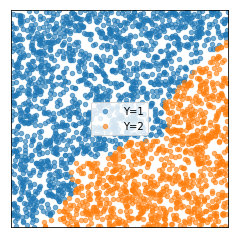

Vizualizing labelset:slice_1:pred from payload_train


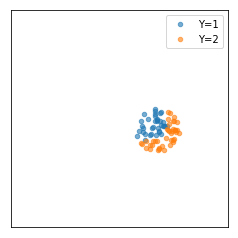

Vizualizing labelset:slice_2:pred from payload_train


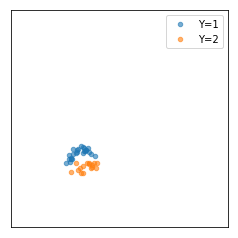

Vizualizing labelset:BASE:pred from payload_train


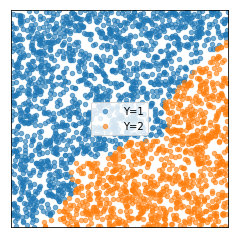


Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_2:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
   

[35.0 epo]: test_task:[payload_train/labelset_gold/loss=8.58e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.58e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.38e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.44e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.29e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] model:[train/all/loss=8.49e-02, train/all/lr=1.00e-02, valid/all/loss=8.37e-02]
[40.0 epo]: test_task:[payload_train/lab

[80.0 epo]: test_task:[payload_train/labelset_gold/loss=8.56e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.56e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.34e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.38e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.44e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.14e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] model:[train/all/loss=8.47e-02, train/all/lr=1.00e-02, valid/all/loss=8.38e-02]
[85.0 epo]: test_task:[payload_train/lab

[125.0 epo]: test_task:[payload_train/labelset_gold/loss=8.56e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.56e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.35e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.09e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.96e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.46e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.52e-01] model:[train/all/loss=8.46e-02, train/all/lr=1.00e-02, valid/all/loss=8.39e-02]
[130.0 epo]: test_task:[payload_train/l

[170.0 epo]: test_task:[payload_train/labelset_gold/loss=8.11e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.11e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.91e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.38e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.44e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.66e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.83e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.02e-01] model:[train/all/loss=8.01e-02, train/all/lr=1.00e-02, valid/all/loss=8.31e-02]
[175.0 epo]: test_task:[payload_train/l

[215.0 epo]: test_task:[payload_train/labelset_gold/loss=8.06e-02, payload_valid/labelset_gold/accuracy=9.67e-01, payload_valid/labelset_gold/f1=9.72e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.06e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01, payload_valid/labelset:BASE:pred/f1=9.72e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.25e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.75e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.89e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.15e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.67e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.08e-01] model:[train/all/loss=7.95e-02, train/all/lr=1.00e-02, valid/all/loss=8.36e-02]
[220.0 epo]: test_task:[payload_train/l

[260.0 epo]: test_task:[payload_train/labelset_gold/loss=8.03e-02, payload_valid/labelset_gold/accuracy=9.67e-01, payload_valid/labelset_gold/f1=9.72e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.03e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01, payload_valid/labelset:BASE:pred/f1=9.72e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.03e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.39e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.58e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=9.51e-03, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01, payload_valid/labelset:slice_2:pred/f1=7.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.43e-01] model:[train/all/loss=7.91e-02, train/all/lr=1.00e-02, valid/all/loss=8.33e-02]
[265.0 epo]: test_task:[payload_train/l

[305.0 epo]: test_task:[payload_train/labelset_gold/loss=8.03e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.03e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.77e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.75e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.89e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.46e-03, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01, payload_valid/labelset:slice_2:pred/f1=7.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.43e-01] model:[train/all/loss=7.91e-02, train/all/lr=1.00e-02, valid/all/loss=8.31e-02]
[310.0 epo]: test_task:[payload_train/l

[350.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.01e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.74e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.75e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.89e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.01e-03, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.62e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.92e-01] model:[train/all/loss=7.89e-02, train/all/lr=1.00e-02, valid/all/loss=8.29e-02]
[355.0 epo]: test_task:[payload_train/l

[395.0 epo]: test_task:[payload_train/labelset_gold/loss=7.92e-02, payload_valid/labelset_gold/accuracy=9.69e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.92e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.81e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.39e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.58e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.90e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.80e-02, train/all/lr=1.00e-02, valid/all/loss=8.18e-02]
[400.0 epo]: test_task:[payload_train/l

[440.0 epo]: test_task:[payload_train/labelset_gold/loss=7.73e-02, payload_valid/labelset_gold/accuracy=9.69e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.67e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.85e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.93e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.61e-02, train/all/lr=1.00e-02, valid/all/loss=8.05e-02]
[445.0 epo]: test_task:[payload_train/l

[485.0 epo]: test_task:[payload_train/labelset_gold/loss=7.54e-02, payload_valid/labelset_gold/accuracy=9.69e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.54e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.67e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.85e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.67e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.42e-02, train/all/lr=1.00e-02, valid/all/loss=7.99e-02]
[490.0 epo]: test_task:[payload_train/l

[530.0 epo]: test_task:[payload_train/labelset_gold/loss=7.43e-02, payload_valid/labelset_gold/accuracy=9.70e-01, payload_valid/labelset_gold/f1=9.74e-01, payload_valid/labelset_gold/acc_f1=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.43e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01, payload_valid/labelset:BASE:pred/f1=9.74e-01, payload_valid/labelset:BASE:pred/acc_f1=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.44e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.67e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.85e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.34e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.31e-02, train/all/lr=1.00e-02, valid/all/loss=7.97e-02]
[535.0 epo]: test_task:[payload_train/l

[575.0 epo]: test_task:[payload_train/labelset_gold/loss=7.34e-02, payload_valid/labelset_gold/accuracy=9.70e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.34e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.67e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.85e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.06e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.22e-02, train/all/lr=1.00e-02, valid/all/loss=7.96e-02]
[580.0 epo]: test_task:[payload_train/l

[620.0 epo]: test_task:[payload_train/labelset_gold/loss=7.25e-02, payload_valid/labelset_gold/accuracy=9.70e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.35e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.28e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.53e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.91e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.14e-02, train/all/lr=1.00e-02, valid/all/loss=7.95e-02]
[625.0 epo]: test_task:[payload_train/l

[665.0 epo]: test_task:[payload_train/labelset_gold/loss=7.19e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.19e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.22e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.57e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.50e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.07e-02, train/all/lr=1.00e-02, valid/all/loss=7.99e-02]
[670.0 epo]: test_task:[payload_train/l

[710.0 epo]: test_task:[payload_train/labelset_gold/loss=7.15e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.15e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.09e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.57e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.23e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.03e-02, train/all/lr=1.00e-02, valid/all/loss=8.03e-02]
[715.0 epo]: test_task:[payload_train/l

[755.0 epo]: test_task:[payload_train/labelset_gold/loss=7.13e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.13e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.91e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.57e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.93e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=7.01e-02, train/all/lr=1.00e-02, valid/all/loss=8.08e-02]
[760.0 epo]: test_task:[payload_train/l

[800.0 epo]: test_task:[payload_train/labelset_gold/loss=7.11e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.11e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.80e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.57e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.78e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.99e-02, train/all/lr=1.00e-02, valid/all/loss=8.11e-02]
[805.0 epo]: test_task:[payload_train/l

[845.0 epo]: test_task:[payload_train/labelset_gold/loss=7.09e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.09e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.77e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01, payload_valid/labelset:slice_1:pred/f1=8.57e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.63e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.97e-02, train/all/lr=1.00e-02, valid/all/loss=8.12e-02]
[850.0 epo]: test_task:[payload_train/l

[890.0 epo]: test_task:[payload_train/labelset_gold/loss=7.07e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.07e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.75e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.15e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.57e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.95e-02, train/all/lr=1.00e-02, valid/all/loss=8.13e-02]
[895.0 epo]: test_task:[payload_train/l

[935.0 epo]: test_task:[payload_train/labelset_gold/loss=7.05e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.05e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.71e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.15e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.46e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.93e-02, train/all/lr=1.00e-02, valid/all/loss=8.14e-02]
[940.0 epo]: test_task:[payload_train/l

[980.0 epo]: test_task:[payload_train/labelset_gold/loss=7.04e-02, payload_valid/labelset_gold/accuracy=9.71e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.04e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.67e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.15e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.43e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.92e-02, train/all/lr=1.00e-02, valid/all/loss=8.15e-02]
[985.0 epo]: test_task:[payload_train/l

[1025.0 epo]: test_task:[payload_train/labelset_gold/loss=7.03e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.03e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.62e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.15e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.45e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.91e-02, train/all/lr=1.00e-02, valid/all/loss=8.16e-02]
[1030.0 epo]: test_task:[payload_train

[1070.0 epo]: test_task:[payload_train/labelset_gold/loss=7.02e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.02e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.56e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.15e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.53e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.90e-02, train/all/lr=1.00e-02, valid/all/loss=8.17e-02]
[1075.0 epo]: test_task:[payload_train

[1115.0 epo]: test_task:[payload_train/labelset_gold/loss=7.01e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.01e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.54e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.15e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.71e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.89e-02, train/all/lr=1.00e-02, valid/all/loss=8.16e-02]
[1120.0 epo]: test_task:[payload_train

[1160.0 epo]: test_task:[payload_train/labelset_gold/loss=7.00e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.00e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.51e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.15e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.05e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.88e-02, train/all/lr=1.00e-02, valid/all/loss=8.15e-02]
[1165.0 epo]: test_task:[payload_train

[1205.0 epo]: test_task:[payload_train/labelset_gold/loss=6.98e-02, payload_valid/labelset_gold/accuracy=9.72e-01, payload_valid/labelset_gold/f1=9.76e-01, payload_valid/labelset_gold/acc_f1=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=6.98e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.45e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01, payload_valid/labelset:slice_1:pred/f1=8.15e-01, payload_valid/labelset:slice_1:pred/acc_f1=8.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.12e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=6.86e-02, train/all/lr=1.00e-02, valid/all/loss=8.15e-02]
[1210.0 epo]: test_task:[payload_train

[1250.0 epo]: test_task:[payload_train/labelset_gold/loss=5.30e-02, payload_valid/labelset_gold/accuracy=9.77e-01, payload_valid/labelset_gold/f1=9.80e-01, payload_valid/labelset_gold/acc_f1=9.79e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.77e-01, payload_valid/labelset:BASE:pred/f1=9.80e-01, payload_valid/labelset:BASE:pred/acc_f1=9.79e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.69e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=8.97e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.12e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.43e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01, payload_valid/labelset:slice_2:pred/f1=6.96e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.23e-01] model:[train/all/loss=5.21e-02, train/all/lr=1.00e-02, valid/all/loss=5.50e-02]
[1255.0 epo]: test_task:[payload_train

[1295.0 epo]: test_task:[payload_train/labelset_gold/loss=4.34e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.84e-01, payload_valid/labelset_gold/acc_f1=9.83e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.30e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.83e-03, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.62e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.92e-01] model:[train/all/loss=4.26e-02, train/all/lr=1.00e-02, valid/all/loss=4.06e-02]
[1300.0 epo]: test_task:[payload_train

[1340.0 epo]: test_task:[payload_train/labelset_gold/loss=3.93e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.93e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.84e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.17e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.38e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.44e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.02e-03, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.62e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.92e-01] model:[train/all/loss=3.85e-02, train/all/lr=1.00e-02, valid/all/loss=3.59e-02]
[1345.0 epo]: test_task:[payload_train

[1385.0 epo]: test_task:[payload_train/labelset_gold/loss=3.73e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.84e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.07e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.41e-04, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.62e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.92e-01] model:[train/all/loss=3.66e-02, train/all/lr=1.00e-02, valid/all/loss=3.46e-02]
[1390.0 epo]: test_task:[payload_train

[1430.0 epo]: test_task:[payload_train/labelset_gold/loss=3.65e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.65e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.84e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.02e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.83e-04, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.62e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.92e-01] model:[train/all/loss=3.58e-02, train/all/lr=1.00e-02, valid/all/loss=3.46e-02]
[1435.0 epo]: test_task:[payload_train

[1475.0 epo]: test_task:[payload_train/labelset_gold/loss=3.61e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.61e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.84e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.78e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.48e-04, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.37e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.79e-01] model:[train/all/loss=3.54e-02, train/all/lr=1.00e-02, valid/all/loss=3.50e-02]
[1480.0 epo]: test_task:[payload_train

[1520.0 epo]: test_task:[payload_train/labelset_gold/loss=3.58e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.58e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.84e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.44e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.79e-05, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.37e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.79e-01] model:[train/all/loss=3.51e-02, train/all/lr=1.00e-02, valid/all/loss=3.49e-02]
[1525.0 epo]: test_task:[payload_train

[1565.0 epo]: test_task:[payload_train/labelset_gold/loss=3.55e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.55e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.25e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.09e-05, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.37e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.79e-01] model:[train/all/loss=3.48e-02, train/all/lr=1.00e-02, valid/all/loss=3.56e-02]
[1570.0 epo]: test_task:[payload_train

[1610.0 epo]: test_task:[payload_train/labelset_gold/loss=3.53e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.53e-02, payload_valid/labelset:BASE:pred/accuracy=9.83e-01, payload_valid/labelset:BASE:pred/f1=9.86e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.14e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.08e-05, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.37e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.79e-01] model:[train/all/loss=3.46e-02, train/all/lr=1.00e-02, valid/all/loss=3.53e-02]
[1615.0 epo]: test_task:[payload_train

[1655.0 epo]: test_task:[payload_train/labelset_gold/loss=3.51e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.17e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.11e-05, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=7.37e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.79e-01] model:[train/all/loss=3.44e-02, train/all/lr=1.00e-02, valid/all/loss=3.60e-02]
[1660.0 epo]: test_task:[payload_train

[1700.0 epo]: test_task:[payload_train/labelset_gold/loss=3.50e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.50e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.23e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.28e-06, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.43e-02, train/all/lr=1.00e-02, valid/all/loss=3.55e-02]
[1705.0 epo]: test_task:[payload_train

[1745.0 epo]: test_task:[payload_train/labelset_gold/loss=3.48e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.48e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.31e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.66e-06, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.42e-02, train/all/lr=1.00e-02, valid/all/loss=3.63e-02]
[1750.0 epo]: test_task:[payload_train

[1790.0 epo]: test_task:[payload_train/labelset_gold/loss=3.47e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.32e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.90e-06, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.40e-02, train/all/lr=1.00e-02, valid/all/loss=3.64e-02]
[1795.0 epo]: test_task:[payload_train

[1835.0 epo]: test_task:[payload_train/labelset_gold/loss=3.46e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.43e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.62e-07, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.40e-02, train/all/lr=1.00e-02, valid/all/loss=3.64e-02]
[1840.0 epo]: test_task:[payload_train

[1880.0 epo]: test_task:[payload_train/labelset_gold/loss=3.46e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.45e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.71e-07, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.39e-02, train/all/lr=1.00e-02, valid/all/loss=3.58e-02]
[1885.0 epo]: test_task:[payload_train

[1925.0 epo]: test_task:[payload_train/labelset_gold/loss=3.46e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.55e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.41e-07, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.39e-02, train/all/lr=1.00e-02, valid/all/loss=3.65e-02]
[1930.0 epo]: test_task:[payload_train

[1970.0 epo]: test_task:[payload_train/labelset_gold/loss=3.46e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.55e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.92e-07, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.39e-02, train/all/lr=1.00e-02, valid/all/loss=3.62e-02]
[1975.0 epo]: test_task:[payload_train

[2015.0 epo]: test_task:[payload_train/labelset_gold/loss=3.46e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.62e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.51e-08, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.39e-02, train/all/lr=1.00e-02, valid/all/loss=3.68e-02]
[2020.0 epo]: test_task:[payload_train

[2060.0 epo]: test_task:[payload_train/labelset_gold/loss=3.46e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.62e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.47e-08, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.39e-02, train/all/lr=1.00e-02, valid/all/loss=3.69e-02]
[2065.0 epo]: test_task:[payload_train

[2105.0 epo]: test_task:[payload_train/labelset_gold/loss=3.46e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.61e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.82e-08, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.39e-02, train/all/lr=1.00e-02, valid/all/loss=3.63e-02]
[2110.0 epo]: test_task:[payload_train

[2150.0 epo]: test_task:[payload_train/labelset_gold/loss=3.46e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.56e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.97e-08, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.40e-02, train/all/lr=1.00e-02, valid/all/loss=3.65e-02]
[2155.0 epo]: test_task:[payload_train

[2195.0 epo]: test_task:[payload_train/labelset_gold/loss=3.47e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.58e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.30e-08, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01, payload_valid/labelset:slice_2:pred/f1=8.57e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.75e-01] model:[train/all/loss=3.40e-02, train/all/lr=1.00e-02, valid/all/loss=3.72e-02]
[2200.0 epo]: test_task:[payload_train

[2240.0 epo]: test_task:[payload_train/labelset_gold/loss=3.47e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.51e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.67e-08, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01, payload_valid/labelset:slice_2:pred/f1=8.57e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.75e-01] model:[train/all/loss=3.41e-02, train/all/lr=1.00e-02, valid/all/loss=3.67e-02]
[2245.0 epo]: test_task:[payload_train

[2285.0 epo]: test_task:[payload_train/labelset_gold/loss=3.48e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.48e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.55e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.18e-08, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01, payload_valid/labelset:slice_2:pred/f1=8.57e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.75e-01] model:[train/all/loss=3.41e-02, train/all/lr=1.00e-02, valid/all/loss=3.75e-02]
[2290.0 epo]: test_task:[payload_train

[2330.0 epo]: test_task:[payload_train/labelset_gold/loss=3.48e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.48e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.53e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.80e-08, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01, payload_valid/labelset:slice_2:pred/f1=8.57e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.75e-01] model:[train/all/loss=3.42e-02, train/all/lr=1.00e-02, valid/all/loss=3.76e-02]
[2335.0 epo]: test_task:[payload_train

[2375.0 epo]: test_task:[payload_train/labelset_gold/loss=3.49e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.49e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.48e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.47e-08, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.29e-01] model:[train/all/loss=3.42e-02, train/all/lr=1.00e-02, valid/all/loss=3.72e-02]
[2380.0 epo]: test_task:[payload_train

[2420.0 epo]: test_task:[payload_train/labelset_gold/loss=3.49e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.49e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.52e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.06e-08, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01, payload_valid/labelset:slice_2:pred/f1=8.57e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.75e-01] model:[train/all/loss=3.42e-02, train/all/lr=1.00e-02, valid/all/loss=3.78e-02]
[2425.0 epo]: test_task:[payload_train

[2465.0 epo]: test_task:[payload_train/labelset_gold/loss=3.49e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.49e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.51e-03, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.44e-08, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01, payload_valid/labelset:slice_2:pred/f1=8.57e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.75e-01] model:[train/all/loss=3.43e-02, train/all/lr=1.00e-02, valid/all/loss=3.79e-02]
[2470.0 epo]: test_task:[payload_train

/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'model/valid/all/loss': 0.037389985089995866,
 'test_task/payload_test/labelset_gold/acc_f1': 0.9768507115135834,
 'test_task/payload_test/labelset_gold/accuracy': 0.9744,
 'test_task/payload_test/labelset_gold/f1': 0.9793014230271668,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9913240310077518,
 'test_task/payload_train/labelset_gold/accuracy': 0.9904,
 'test_task/payload_train/labelset_gold/f1': 0.9922480620155038,
 'test_task/payload_valid/labelset_gold/acc_f1': 0.986727125506073,
 'test_task/payload_valid/labelset_gold/accuracy': 0.9856,
 'test_task/payload_valid/labelset_gold/f1': 0.9878542510121459,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/acc_f1': 0.9768507115135834,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9744,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/f1': 0.9793014230271668,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/acc_f1': 0.9913240310077518,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/accu

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


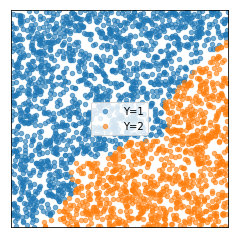

Vizualizing labelset:slice_1:pred from payload_train


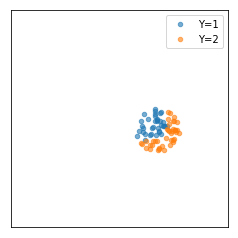

Vizualizing labelset:slice_2:pred from payload_train


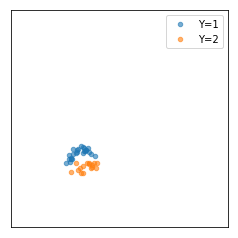

Vizualizing labelset:BASE:pred from payload_train


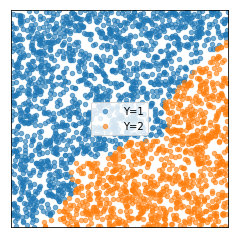


Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_2:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
   

[35.0 epo]: test_task:[payload_train/labelset_gold/loss=9.89e-02, payload_valid/labelset_gold/accuracy=9.76e-01, payload_valid/labelset_gold/f1=9.80e-01, payload_valid/labelset_gold/acc_f1=9.78e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=9.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.76e-01, payload_valid/labelset:BASE:pred/f1=9.80e-01, payload_valid/labelset:BASE:pred/acc_f1=9.78e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.12e+01, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.38e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.44e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.16e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=4.18e-01, train/all/lr=1.00e-02, valid/all/loss=2.14e-01]
[40.0 epo]: test_task:[payload_train/lab

[80.0 epo]: test_task:[payload_train/labelset_gold/loss=9.12e-02, payload_valid/labelset_gold/accuracy=9.74e-01, payload_valid/labelset_gold/f1=9.78e-01, payload_valid/labelset_gold/acc_f1=9.76e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=9.12e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.90e+01, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.70e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.73e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=5.28e-01, train/all/lr=1.00e-02, valid/all/loss=2.35e-01]
[85.0 epo]: test_task:[payload_train/lab

[125.0 epo]: test_task:[payload_train/labelset_gold/loss=9.01e-02, payload_valid/labelset_gold/accuracy=9.74e-01, payload_valid/labelset_gold/f1=9.78e-01, payload_valid/labelset_gold/acc_f1=9.76e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=9.01e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.45e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.84e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.15e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.18e-01] model:[train/all/loss=6.09e-01, train/all/lr=1.00e-02, valid/all/loss=2.79e-01]
[130.0 epo]: test_task:[payload_train/l

[170.0 epo]: test_task:[payload_train/labelset_gold/loss=8.40e-02, payload_valid/labelset_gold/accuracy=9.70e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01, payload_valid/labelset:BASE:pred/f1=9.75e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.37e+01, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.41e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.46e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.38e-01, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.57e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.57e-01] model:[train/all/loss=5.90e-01, train/all/lr=1.00e-02, valid/all/loss=2.48e-01]
[175.0 epo]: test_task:[payload_train/l

[215.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.69e-01, payload_valid/labelset_gold/f1=9.74e-01, payload_valid/labelset_gold/acc_f1=9.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01, payload_valid/labelset:BASE:pred/f1=9.74e-01, payload_valid/labelset:BASE:pred/acc_f1=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.83e+01, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.70e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.73e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.02e-01, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01, payload_valid/labelset:slice_2:pred/f1=7.69e-01, payload_valid/labelset:slice_2:pred/acc_f1=7.77e-01] model:[train/all/loss=5.07e-01, train/all/lr=1.00e-02, valid/all/loss=2.16e-01]
[220.0 epo]: test_task:[payload_train/l

[260.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.08e+01, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.70e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.73e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.37e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=3.94e-01, train/all/lr=1.00e-02, valid/all/loss=2.08e-01]
[265.0 epo]: test_task:[payload_train/l

[305.0 epo]: test_task:[payload_train/labelset_gold/loss=8.23e-02, payload_valid/labelset_gold/accuracy=9.69e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.25e+01, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.70e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.73e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=2.70e-01, train/all/lr=1.00e-02, valid/all/loss=1.37e-01]
[310.0 epo]: test_task:[payload_train/l

[350.0 epo]: test_task:[payload_train/labelset_gold/loss=8.18e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.18e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.39e+00, payload_valid/labelset:slice_1:pred/accuracy=1.00e+00, payload_valid/labelset:slice_1:pred/f1=1.00e+00, payload_valid/labelset:slice_1:pred/acc_f1=1.00e+00] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.24e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.92e-01, train/all/lr=1.00e-02, valid/all/loss=1.06e-01]
[355.0 epo]: test_task:[payload_train/l

[395.0 epo]: test_task:[payload_train/labelset_gold/loss=8.15e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.15e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.17e+00, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.33e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.42e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.56e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.58e-01, train/all/lr=1.00e-02, valid/all/loss=1.25e-01]
[400.0 epo]: test_task:[payload_train/l

[440.0 epo]: test_task:[payload_train/labelset_gold/loss=8.21e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.21e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.08e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=8.97e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.12e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.28e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.57e-01, train/all/lr=1.00e-02, valid/all/loss=2.01e-01]
[445.0 epo]: test_task:[payload_train/l

[485.0 epo]: test_task:[payload_train/labelset_gold/loss=8.24e-02, payload_valid/labelset_gold/accuracy=9.67e-01, payload_valid/labelset_gold/f1=9.72e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01, payload_valid/labelset:BASE:pred/f1=9.72e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.96e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.29e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.41e-01, train/all/lr=1.00e-02, valid/all/loss=1.86e-01]
[490.0 epo]: test_task:[payload_train/l

[530.0 epo]: test_task:[payload_train/labelset_gold/loss=8.25e-02, payload_valid/labelset_gold/accuracy=9.67e-01, payload_valid/labelset_gold/f1=9.72e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01, payload_valid/labelset:BASE:pred/f1=9.72e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.09e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.42e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.27e-01, train/all/lr=1.00e-02, valid/all/loss=1.79e-01]
[535.0 epo]: test_task:[payload_train/l

[575.0 epo]: test_task:[payload_train/labelset_gold/loss=8.23e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.72e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.32e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.22e-01, train/all/lr=1.00e-02, valid/all/loss=1.77e-01]
[580.0 epo]: test_task:[payload_train/l

[620.0 epo]: test_task:[payload_train/labelset_gold/loss=8.21e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.21e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.63e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.04e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.20e-01, train/all/lr=1.00e-02, valid/all/loss=1.78e-01]
[625.0 epo]: test_task:[payload_train/l

[665.0 epo]: test_task:[payload_train/labelset_gold/loss=8.18e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.18e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.69e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.69e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.21e-01, train/all/lr=1.00e-02, valid/all/loss=1.82e-01]
[670.0 epo]: test_task:[payload_train/l

[710.0 epo]: test_task:[payload_train/labelset_gold/loss=8.19e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.19e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.81e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.78e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.23e-01, train/all/lr=1.00e-02, valid/all/loss=1.78e-01]
[715.0 epo]: test_task:[payload_train/l

[755.0 epo]: test_task:[payload_train/labelset_gold/loss=8.19e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.19e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01, payload_valid/labelset:BASE:pred/f1=9.73e-01, payload_valid/labelset:BASE:pred/acc_f1=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.79e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.22e-01, train/all/lr=1.00e-02, valid/all/loss=1.75e-01]
[760.0 epo]: test_task:[payload_train/l

[800.0 epo]: test_task:[payload_train/labelset_gold/loss=7.09e-02, payload_valid/labelset_gold/accuracy=9.73e-01, payload_valid/labelset_gold/f1=9.77e-01, payload_valid/labelset_gold/acc_f1=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.09e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01, payload_valid/labelset:BASE:pred/f1=9.77e-01, payload_valid/labelset:BASE:pred/acc_f1=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.84e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.60e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.12e-01, train/all/lr=1.00e-02, valid/all/loss=1.72e-01]
[805.0 epo]: test_task:[payload_train/l

[845.0 epo]: test_task:[payload_train/labelset_gold/loss=5.90e-02, payload_valid/labelset_gold/accuracy=9.78e-01, payload_valid/labelset_gold/f1=9.81e-01, payload_valid/labelset_gold/acc_f1=9.79e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.78e-01, payload_valid/labelset:BASE:pred/f1=9.81e-01, payload_valid/labelset:BASE:pred/acc_f1=9.79e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.61e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.64e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=9.72e-02, train/all/lr=1.00e-02, valid/all/loss=2.02e-01]
[850.0 epo]: test_task:[payload_train/l

[890.0 epo]: test_task:[payload_train/labelset_gold/loss=5.30e-02, payload_valid/labelset_gold/accuracy=9.79e-01, payload_valid/labelset_gold/f1=9.82e-01, payload_valid/labelset_gold/acc_f1=9.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.79e-01, payload_valid/labelset:BASE:pred/f1=9.82e-01, payload_valid/labelset:BASE:pred/acc_f1=9.81e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.72e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.64e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.08e-01, train/all/lr=1.00e-02, valid/all/loss=2.68e-01]
[895.0 epo]: test_task:[payload_train/l

[935.0 epo]: test_task:[payload_train/labelset_gold/loss=4.99e-02, payload_valid/labelset_gold/accuracy=9.79e-01, payload_valid/labelset_gold/f1=9.82e-01, payload_valid/labelset_gold/acc_f1=9.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.99e-02, payload_valid/labelset:BASE:pred/accuracy=9.79e-01, payload_valid/labelset:BASE:pred/f1=9.82e-01, payload_valid/labelset:BASE:pred/acc_f1=9.81e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.36e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.99e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.15e-01, train/all/lr=1.00e-02, valid/all/loss=3.47e-01]
[940.0 epo]: test_task:[payload_train/l

[980.0 epo]: test_task:[payload_train/labelset_gold/loss=4.80e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.84e-01, payload_valid/labelset_gold/acc_f1=9.83e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.80e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.89e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.13e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.21e-01, train/all/lr=1.00e-02, valid/all/loss=3.88e-01]
[985.0 epo]: test_task:[payload_train/l

[1025.0 epo]: test_task:[payload_train/labelset_gold/loss=4.73e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.83e-01, payload_valid/labelset:BASE:pred/f1=9.86e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.26e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.50e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.26e-01, train/all/lr=1.00e-02, valid/all/loss=4.15e-01]
[1030.0 epo]: test_task:[payload_train

[1070.0 epo]: test_task:[payload_train/labelset_gold/loss=4.65e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.65e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.44e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.78e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.28e-01, train/all/lr=1.00e-02, valid/all/loss=4.72e-01]
[1075.0 epo]: test_task:[payload_train

[1115.0 epo]: test_task:[payload_train/labelset_gold/loss=4.44e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.44e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.86e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.47e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.32e-01, train/all/lr=1.00e-02, valid/all/loss=6.05e-01]
[1120.0 epo]: test_task:[payload_train

[1160.0 epo]: test_task:[payload_train/labelset_gold/loss=4.19e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.19e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.77e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.27e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.44e-01, train/all/lr=1.00e-02, valid/all/loss=7.30e-01]
[1165.0 epo]: test_task:[payload_train

[1205.0 epo]: test_task:[payload_train/labelset_gold/loss=4.03e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.03e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.44e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.26e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.52e-01, train/all/lr=1.00e-02, valid/all/loss=7.64e-01]
[1210.0 epo]: test_task:[payload_train

[1250.0 epo]: test_task:[payload_train/labelset_gold/loss=3.96e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.96e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.26e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.62e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.49e-01, train/all/lr=1.00e-02, valid/all/loss=7.53e-01]
[1255.0 epo]: test_task:[payload_train

[1295.0 epo]: test_task:[payload_train/labelset_gold/loss=3.93e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.93e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.67e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.32e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=1.39e-01, train/all/lr=1.00e-02, valid/all/loss=7.21e-01]
[1300.0 epo]: test_task:[payload_train

[1340.0 epo]: test_task:[payload_train/labelset_gold/loss=3.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.83e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.16e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.33e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.45e-01] model:[train/all/loss=1.26e-01, train/all/lr=1.00e-02, valid/all/loss=6.84e-01]
[1345.0 epo]: test_task:[payload_train

[1385.0 epo]: test_task:[payload_train/labelset_gold/loss=3.86e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.86e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.85e+00, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.03e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.15e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.19e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.33e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.45e-01] model:[train/all/loss=1.11e-01, train/all/lr=1.00e-02, valid/all/loss=6.32e-01]
[1390.0 epo]: test_task:[payload_train

[1430.0 epo]: test_task:[payload_train/labelset_gold/loss=3.83e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.83e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.94e+00, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.33e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.42e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.30e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01, payload_valid/labelset:slice_2:pred/f1=8.33e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.45e-01] model:[train/all/loss=9.69e-02, train/all/lr=1.00e-02, valid/all/loss=5.69e-01]
[1435.0 epo]: test_task:[payload_train

[1475.0 epo]: test_task:[payload_train/labelset_gold/loss=3.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.22e+00, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.33e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.42e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.60e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=8.58e-02, train/all/lr=1.00e-02, valid/all/loss=4.95e-01]
[1480.0 epo]: test_task:[payload_train

[1520.0 epo]: test_task:[payload_train/labelset_gold/loss=3.78e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.67e+00, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.33e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.42e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.10e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=7.72e-02, train/all/lr=1.00e-02, valid/all/loss=4.19e-01]
[1525.0 epo]: test_task:[payload_train

[1565.0 epo]: test_task:[payload_train/labelset_gold/loss=3.75e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.75e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.30e+00, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.33e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.42e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.49e-03, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=7.14e-02, train/all/lr=1.00e-02, valid/all/loss=3.53e-01]
[1570.0 epo]: test_task:[payload_train

[1610.0 epo]: test_task:[payload_train/labelset_gold/loss=3.72e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.01e+00, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.33e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.42e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.37e-03, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.66e-02, train/all/lr=1.00e-02, valid/all/loss=2.84e-01]
[1615.0 epo]: test_task:[payload_train

[1655.0 epo]: test_task:[payload_train/labelset_gold/loss=3.71e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.87e+00, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01, payload_valid/labelset:slice_1:pred/f1=9.33e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.42e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.48e-03, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.44e-02, train/all/lr=1.00e-02, valid/all/loss=2.24e-01]
[1660.0 epo]: test_task:[payload_train

[1700.0 epo]: test_task:[payload_train/labelset_gold/loss=3.70e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.86e-01, payload_valid/labelset:BASE:pred/f1=9.88e-01, payload_valid/labelset:BASE:pred/acc_f1=9.87e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.72e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.08e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.20e-02, train/all/lr=1.00e-02, valid/all/loss=1.73e-01]
[1705.0 epo]: test_task:[payload_train

[1745.0 epo]: test_task:[payload_train/labelset_gold/loss=3.70e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.60e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.89e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.02e-02, train/all/lr=1.00e-02, valid/all/loss=1.59e-01]
[1750.0 epo]: test_task:[payload_train

[1790.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.47e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.15e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=5.82e-02, train/all/lr=1.00e-02, valid/all/loss=1.38e-01]
[1795.0 epo]: test_task:[payload_train

[1835.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.43e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.95e-03, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=5.76e-02, train/all/lr=1.00e-02, valid/all/loss=1.35e-01]
[1840.0 epo]: test_task:[payload_train

[1880.0 epo]: test_task:[payload_train/labelset_gold/loss=3.70e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.48e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.71e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=5.84e-02, train/all/lr=1.00e-02, valid/all/loss=1.34e-01]
[1885.0 epo]: test_task:[payload_train

[1925.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.49e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.16e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=5.87e-02, train/all/lr=1.00e-02, valid/all/loss=1.35e-01]
[1930.0 epo]: test_task:[payload_train

[1970.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.54e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.02e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=5.92e-02, train/all/lr=1.00e-02, valid/all/loss=1.36e-01]
[1975.0 epo]: test_task:[payload_train

[2015.0 epo]: test_task:[payload_train/labelset_gold/loss=3.70e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.58e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.73e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=5.99e-02, train/all/lr=1.00e-02, valid/all/loss=1.37e-01]
[2020.0 epo]: test_task:[payload_train

[2060.0 epo]: test_task:[payload_train/labelset_gold/loss=3.70e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.63e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.60e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.06e-02, train/all/lr=1.00e-02, valid/all/loss=1.38e-01]
[2065.0 epo]: test_task:[payload_train

[2105.0 epo]: test_task:[payload_train/labelset_gold/loss=3.70e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.67e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.51e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.12e-02, train/all/lr=1.00e-02, valid/all/loss=1.39e-01]
[2110.0 epo]: test_task:[payload_train

[2150.0 epo]: test_task:[payload_train/labelset_gold/loss=3.70e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.85e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.86e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.69e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.34e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.15e-02, train/all/lr=1.00e-02, valid/all/loss=1.39e-01]
[2155.0 epo]: test_task:[payload_train

[2195.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.70e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.09e-04, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.17e-02, train/all/lr=1.00e-02, valid/all/loss=1.40e-01]
[2200.0 epo]: test_task:[payload_train

[2240.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.73e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.84e-05, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.21e-02, train/all/lr=1.00e-02, valid/all/loss=1.41e-01]
[2245.0 epo]: test_task:[payload_train

[2285.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.80e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.75e-05, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.31e-02, train/all/lr=1.00e-02, valid/all/loss=1.42e-01]
[2290.0 epo]: test_task:[payload_train

[2330.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.87e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.33e-05, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.42e-02, train/all/lr=1.00e-02, valid/all/loss=1.43e-01]
[2335.0 epo]: test_task:[payload_train

[2375.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.95e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.16e-05, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.53e-02, train/all/lr=1.00e-02, valid/all/loss=1.45e-01]
[2380.0 epo]: test_task:[payload_train

[2420.0 epo]: test_task:[payload_train/labelset_gold/loss=3.68e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.01e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.30e-05, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01, payload_valid/labelset:slice_2:pred/f1=8.57e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.75e-01] model:[train/all/loss=6.63e-02, train/all/lr=1.00e-02, valid/all/loss=1.47e-01]
[2425.0 epo]: test_task:[payload_train

[2465.0 epo]: test_task:[payload_train/labelset_gold/loss=3.68e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.84e-01, payload_valid/labelset:BASE:pred/f1=9.87e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.06e+00, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01, payload_valid/labelset:slice_1:pred/f1=9.68e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.72e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.35e-05, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01, payload_valid/labelset:slice_2:pred/f1=9.09e-01, payload_valid/labelset:slice_2:pred/acc_f1=9.19e-01] model:[train/all/loss=6.70e-02, train/all/lr=1.00e-02, valid/all/loss=1.47e-01]
[2470.0 epo]: test_task:[payload_train

/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'model/valid/all/loss': 0.14817603282415986,
 'test_task/payload_test/labelset_gold/acc_f1': 0.9768640826873385,
 'test_task/payload_test/labelset_gold/accuracy': 0.9744,
 'test_task/payload_test/labelset_gold/f1': 0.979328165374677,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9906010335917312,
 'test_task/payload_train/labelset_gold/accuracy': 0.9896,
 'test_task/payload_train/labelset_gold/f1': 0.9916020671834624,
 'test_task/payload_valid/labelset_gold/acc_f1': 0.9852614555256065,
 'test_task/payload_valid/labelset_gold/accuracy': 0.984,
 'test_task/payload_valid/labelset_gold/f1': 0.986522911051213,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/acc_f1': 0.9768640826873385,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9744,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/f1': 0.979328165374677,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/acc_f1': 0.9906010335917312,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/accuracy

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


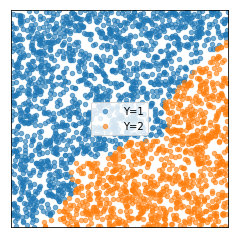

Creating 1 tasks...
BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)
[BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)]
[Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train), Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid), Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)]
No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (expert:slice_1:pred): Dat

[105.0 epo]: expert:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.05e-01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] model:[train/all/loss=4.05e-01, train/all/lr=1.00e-02, valid/all/loss=1.65e-01]
[110.0 epo]: expert:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.95e-01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] model:[train/all/loss=3.95e-01, train/all/lr=1.00e-02, valid/all/loss=1.65e-01]
[115.0 epo]: expert:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.03e-01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] model:[train/all/loss=4.03e-01, train/all/lr=1.00e-02, valid/all/loss=1.56e-01]
[120.0 epo]: expert:slice_1:pred:[

[234.88 epo]: expert:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.95e-01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01, payload_valid/labelset:slice_1:pred/f1=9.14e-01, payload_valid/labelset:slice_1:pred/acc_f1=9.21e-01] model:[train/all/loss=3.95e-01, train/all/lr=1.00e-02, valid/all/loss=1.57e-01]
Finished training


/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'expert:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9174208144796381,
 'expert:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
 'expert:slice_1:pred/payload_test/labelset:slice_1:pred/f1': 0.9230769230769231,
 'expert:slice_1:pred/payload_train/labelset:slice_1:pred/acc_f1': 0.8532289628180039,
 'expert:slice_1:pred/payload_train/labelset:slice_1:pred/accuracy': 0.8571428571428571,
 'expert:slice_1:pred/payload_train/labelset:slice_1:pred/f1': 0.8493150684931507,
 'expert:slice_1:pred/payload_valid/labelset:slice_1:pred/acc_f1': 0.9205574912891986,
 'expert:slice_1:pred/payload_valid/labelset:slice_1:pred/accuracy': 0.926829268292683,
 'expert:slice_1:pred/payload_valid/labelset:slice_1:pred/f1': 0.9142857142857143,
 'model/valid/all/loss': 0.15704294529048018}
Cleaning checkpoints
Writing metrics to /home/hazymturk/metal/logs/2019_05_19/08_53_59/metrics.json
Writing log to /home/hazymturk/metal/logs/2019_05_19/08_53_59/log.json
Full model

[75.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.37e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=4.37e-02, train/all/lr=1.00e-02, valid/all/loss=6.03e-01]
[80.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.32e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=4.32e-02, train/all/lr=1.00e-02, valid/all/loss=6.48e-01]
[85.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.21e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01, payload_valid/labelset:slice_2:pred/f1=8.00e-01, payload_valid/labelset:slice_2:pred/acc_f1=8.11e-01] model:[train/all/loss=4.21e-02, train/all/lr=1.00e-02, valid/all/loss=6.96e-01]
[90.0 epo]: expert:slice_2:pred:[payl

/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'expert:slice_2:pred/payload_test/labelset:slice_2:pred/acc_f1': 0.7991071428571428,
 'expert:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.8125,
 'expert:slice_2:pred/payload_test/labelset:slice_2:pred/f1': 0.7857142857142857,
 'expert:slice_2:pred/payload_train/labelset:slice_2:pred/acc_f1': 0.9780009564801531,
 'expert:slice_2:pred/payload_train/labelset:slice_2:pred/accuracy': 0.975609756097561,
 'expert:slice_2:pred/payload_train/labelset:slice_2:pred/f1': 0.9803921568627451,
 'expert:slice_2:pred/payload_valid/labelset:slice_2:pred/acc_f1': 0.7678571428571428,
 'expert:slice_2:pred/payload_valid/labelset:slice_2:pred/accuracy': 0.7857142857142857,
 'expert:slice_2:pred/payload_valid/labelset:slice_2:pred/f1': 0.75,
 'model/valid/all/loss': 1.269870901442763}
Cleaning checkpoints
Writing metrics to /home/hazymturk/metal/logs/2019_05_19/08_55_34/metrics.json
Writing log to /home/hazymturk/metal/logs/2019_05_19/08_55_34/log.json
Full model saved at /home/hazymturk/me

[80.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.51e-02, train/all/lr=1.00e-02, valid/all/loss=8.49e-02]
[85.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.51e-02, train/all/lr=1.00e-02, valid/all/loss=8.49e-02]
[90.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.51e-02, train/all/lr=1.00e-02, valid/all/loss=8.49e-02]
[95.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payl

[215.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.47e-02, train/all/lr=1.00e-02, valid/all/loss=8.49e-02]
[220.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.45e-02, train/all/lr=1.00e-02, valid/all/loss=8.49e-02]
[225.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.43e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.43e-02, train/all/lr=1.00e-02, valid/all/loss=8.47e-02]
[230.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.39e-02, 

[350.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.21e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.21e-02, train/all/lr=1.00e-02, valid/all/loss=8.51e-02]
[355.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.21e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.21e-02, train/all/lr=1.00e-02, valid/all/loss=8.51e-02]
[360.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.21e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.21e-02, train/all/lr=1.00e-02, valid/all/loss=8.51e-02]
[365.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.21e-02, 

[485.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.20e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.20e-02, train/all/lr=1.00e-02, valid/all/loss=8.53e-02]
[490.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.20e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.20e-02, train/all/lr=1.00e-02, valid/all/loss=8.53e-02]
[495.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.20e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.20e-02, train/all/lr=1.00e-02, valid/all/loss=8.53e-02]
[500.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.20e-02, 

[620.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.19e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.19e-02, train/all/lr=1.00e-02, valid/all/loss=8.53e-02]
[625.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.19e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] model:[train/all/loss=8.19e-02, train/all/lr=1.00e-02, valid/all/loss=8.53e-02]
[625.01 epo]: model:[train/all/lr=1.00e-02, valid/all/loss=8.53e-02] expert:BASE:pred:[payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01]
Finished training


/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'expert:BASE:pred/payload_test/labelset:BASE:pred/acc_f1': 0.968058409387223,
 'expert:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9648,
 'expert:BASE:pred/payload_test/labelset:BASE:pred/f1': 0.971316818774446,
 'expert:BASE:pred/payload_train/labelset:BASE:pred/acc_f1': 0.97311639451339,
 'expert:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.9704,
 'expert:BASE:pred/payload_train/labelset:BASE:pred/f1': 0.97583278902678,
 'expert:BASE:pred/payload_valid/labelset:BASE:pred/acc_f1': 0.974135593220339,
 'expert:BASE:pred/payload_valid/labelset:BASE:pred/accuracy': 0.972,
 'expert:BASE:pred/payload_valid/labelset:BASE:pred/f1': 0.976271186440678,
 'model/valid/all/loss': 0.08534794960319995}
Cleaning checkpoints
Writing metrics to /home/hazymturk/metal/logs/2019_05_19/08_56_53/metrics.json
Writing log to /home/hazymturk/metal/logs/2019_05_19/08_56_53/log.json
Full model saved at /home/hazymturk/metal/logs/2019_05_19/08_56_53/model.pkl
{'expert:BASE:pred/payload_test

[120.0 epo]: test_task:[payload_train/labelset_gold/loss=5.61e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.83e-01] model:[train/all/loss=5.61e-02, train/all/lr=1.00e-02, valid/all/loss=5.68e-02]
[125.0 epo]: test_task:[payload_train/labelset_gold/loss=5.47e-02, payload_valid/labelset_gold/accuracy=9.80e-01, payload_valid/labelset_gold/f1=9.83e-01, payload_valid/labelset_gold/acc_f1=9.82e-01] model:[train/all/loss=5.47e-02, train/all/lr=1.00e-02, valid/all/loss=5.69e-02]
[130.0 epo]: test_task:[payload_train/labelset_gold/loss=5.37e-02, payload_valid/labelset_gold/accuracy=9.80e-01, payload_valid/labelset_gold/f1=9.83e-01, payload_valid/labelset_gold/acc_f1=9.82e-01] model:[train/all/loss=5.37e-02, train/all/lr=1.00e-02, valid/all/loss=5.74e-02]
[135.0 epo]: test_task:[payload_train/labelset_gold/loss=5.32e-02, payload_valid/labelset_gold/accuracy=9.80e-01, payload_valid/labelset_gold/f1=9.83e-01, paylo

[270.0 epo]: test_task:[payload_train/labelset_gold/loss=4.37e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] model:[train/all/loss=4.37e-02, train/all/lr=1.00e-02, valid/all/loss=5.38e-02]
[275.0 epo]: test_task:[payload_train/labelset_gold/loss=4.40e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.83e-01] model:[train/all/loss=4.40e-02, train/all/lr=1.00e-02, valid/all/loss=5.47e-02]
[280.0 epo]: test_task:[payload_train/labelset_gold/loss=4.43e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] model:[train/all/loss=4.43e-02, train/all/lr=1.00e-02, valid/all/loss=5.35e-02]
[285.0 epo]: test_task:[payload_train/labelset_gold/loss=4.50e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, paylo

[420.0 epo]: test_task:[payload_train/labelset_gold/loss=4.38e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] model:[train/all/loss=4.38e-02, train/all/lr=1.00e-02, valid/all/loss=5.41e-02]
[425.0 epo]: test_task:[payload_train/labelset_gold/loss=4.29e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] model:[train/all/loss=4.29e-02, train/all/lr=1.00e-02, valid/all/loss=5.53e-02]
[430.0 epo]: test_task:[payload_train/labelset_gold/loss=4.39e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] model:[train/all/loss=4.39e-02, train/all/lr=1.00e-02, valid/all/loss=5.46e-02]
[435.0 epo]: test_task:[payload_train/labelset_gold/loss=4.35e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, paylo

[570.0 epo]: test_task:[payload_train/labelset_gold/loss=4.35e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] model:[train/all/loss=4.35e-02, train/all/lr=1.00e-02, valid/all/loss=5.77e-02]
[575.0 epo]: test_task:[payload_train/labelset_gold/loss=4.32e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] model:[train/all/loss=4.32e-02, train/all/lr=1.00e-02, valid/all/loss=6.03e-02]
[580.0 epo]: test_task:[payload_train/labelset_gold/loss=4.36e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] model:[train/all/loss=4.36e-02, train/all/lr=1.00e-02, valid/all/loss=5.82e-02]
[585.0 epo]: test_task:[payload_train/labelset_gold/loss=4.40e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, paylo

/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'model/valid/all/loss': 0.057374340724945065,
 'test_task/payload_test/labelset_gold/acc_f1': 0.9848038834951456,
 'test_task/payload_test/labelset_gold/accuracy': 0.9832,
 'test_task/payload_test/labelset_gold/f1': 0.9864077669902912,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9891456310679612,
 'test_task/payload_train/labelset_gold/accuracy': 0.988,
 'test_task/payload_train/labelset_gold/f1': 0.9902912621359223,
 'test_task/payload_valid/labelset_gold/acc_f1': 0.9867189189189189,
 'test_task/payload_valid/labelset_gold/accuracy': 0.9856,
 'test_task/payload_valid/labelset_gold/f1': 0.9878378378378379}
Cleaning checkpoints
Writing metrics to /home/hazymturk/metal/logs/2019_05_19/08_59_27/metrics.json
Writing log to /home/hazymturk/metal/logs/2019_05_19/08_59_27/log.json
Full model saved at /home/hazymturk/metal/logs/2019_05_19/08_59_27/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9832, 'test_task/payload_test/labelset_gold/f1': 0.9864077669902912, 'test_tas

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


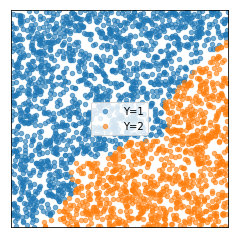


Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (attention_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (head_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=7, out_features=1, bias=True)
      )
    )
  )
)

Total number of parameters: 29
Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /home/hazymturk/metal/logs/2019_05_19/09_03_03/

[135.0 epo]: test_task:[payload_train/labelset_gold/loss=7.56e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] model:[train/all/loss=7.56e-02, train/all/lr=1.00e-02, valid/all/loss=8.16e-02]
[140.0 epo]: test_task:[payload_train/labelset_gold/loss=7.54e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] model:[train/all/loss=7.54e-02, train/all/lr=1.00e-02, valid/all/loss=8.17e-02]
[145.0 epo]: test_task:[payload_train/labelset_gold/loss=7.53e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.70e-01] model:[train/all/loss=7.53e-02, train/all/lr=1.00e-02, valid/all/loss=8.18e-02]
[150.0 epo]: test_task:[payload_train/labelset_gold/loss=7.52e-02, payload_valid/labelset_gold/accuracy=9.68e-01, payload_valid/labelset_gold/f1=9.73e-01, paylo

[285.0 epo]: test_task:[payload_train/labelset_gold/loss=6.83e-02, payload_valid/labelset_gold/accuracy=9.70e-01, payload_valid/labelset_gold/f1=9.74e-01, payload_valid/labelset_gold/acc_f1=9.72e-01] model:[train/all/loss=6.83e-02, train/all/lr=1.00e-02, valid/all/loss=7.46e-02]
[290.0 epo]: test_task:[payload_train/labelset_gold/loss=6.77e-02, payload_valid/labelset_gold/accuracy=9.69e-01, payload_valid/labelset_gold/f1=9.73e-01, payload_valid/labelset_gold/acc_f1=9.71e-01] model:[train/all/loss=6.77e-02, train/all/lr=1.00e-02, valid/all/loss=7.41e-02]
[295.0 epo]: test_task:[payload_train/labelset_gold/loss=6.72e-02, payload_valid/labelset_gold/accuracy=9.70e-01, payload_valid/labelset_gold/f1=9.75e-01, payload_valid/labelset_gold/acc_f1=9.73e-01] model:[train/all/loss=6.72e-02, train/all/lr=1.00e-02, valid/all/loss=7.36e-02]
[300.0 epo]: test_task:[payload_train/labelset_gold/loss=6.67e-02, payload_valid/labelset_gold/accuracy=9.70e-01, payload_valid/labelset_gold/f1=9.74e-01, paylo

[435.0 epo]: test_task:[payload_train/labelset_gold/loss=3.69e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] model:[train/all/loss=3.69e-02, train/all/lr=1.00e-02, valid/all/loss=4.11e-02]
[440.0 epo]: test_task:[payload_train/labelset_gold/loss=3.62e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] model:[train/all/loss=3.62e-02, train/all/lr=1.00e-02, valid/all/loss=4.04e-02]
[445.0 epo]: test_task:[payload_train/labelset_gold/loss=3.56e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] model:[train/all/loss=3.56e-02, train/all/lr=1.00e-02, valid/all/loss=4.00e-02]
[450.0 epo]: test_task:[payload_train/labelset_gold/loss=3.51e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, paylo

[585.0 epo]: test_task:[payload_train/labelset_gold/loss=2.73e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] model:[train/all/loss=2.73e-02, train/all/lr=1.00e-02, valid/all/loss=2.88e-02]
[590.0 epo]: test_task:[payload_train/labelset_gold/loss=2.72e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] model:[train/all/loss=2.72e-02, train/all/lr=1.00e-02, valid/all/loss=2.83e-02]
[595.0 epo]: test_task:[payload_train/labelset_gold/loss=2.70e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] model:[train/all/loss=2.70e-02, train/all/lr=1.00e-02, valid/all/loss=2.84e-02]
[600.0 epo]: test_task:[payload_train/labelset_gold/loss=2.68e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, paylo

[735.0 epo]: test_task:[payload_train/labelset_gold/loss=2.17e-02, payload_valid/labelset_gold/accuracy=9.88e-01, payload_valid/labelset_gold/f1=9.90e-01, payload_valid/labelset_gold/acc_f1=9.89e-01] model:[train/all/loss=2.17e-02, train/all/lr=1.00e-02, valid/all/loss=2.43e-02]
[740.0 epo]: test_task:[payload_train/labelset_gold/loss=2.16e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] model:[train/all/loss=2.16e-02, train/all/lr=1.00e-02, valid/all/loss=2.36e-02]
[745.0 epo]: test_task:[payload_train/labelset_gold/loss=2.15e-02, payload_valid/labelset_gold/accuracy=9.88e-01, payload_valid/labelset_gold/f1=9.90e-01, payload_valid/labelset_gold/acc_f1=9.89e-01] model:[train/all/loss=2.15e-02, train/all/lr=1.00e-02, valid/all/loss=2.40e-02]
[750.0 epo]: test_task:[payload_train/labelset_gold/loss=2.13e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, paylo

[885.0 epo]: test_task:[payload_train/labelset_gold/loss=1.92e-02, payload_valid/labelset_gold/accuracy=9.90e-01, payload_valid/labelset_gold/f1=9.92e-01, payload_valid/labelset_gold/acc_f1=9.91e-01] model:[train/all/loss=1.92e-02, train/all/lr=1.00e-02, valid/all/loss=1.90e-02]
[890.0 epo]: test_task:[payload_train/labelset_gold/loss=1.89e-02, payload_valid/labelset_gold/accuracy=9.90e-01, payload_valid/labelset_gold/f1=9.92e-01, payload_valid/labelset_gold/acc_f1=9.91e-01] model:[train/all/loss=1.89e-02, train/all/lr=1.00e-02, valid/all/loss=1.82e-02]
[895.0 epo]: test_task:[payload_train/labelset_gold/loss=1.85e-02, payload_valid/labelset_gold/accuracy=9.92e-01, payload_valid/labelset_gold/f1=9.93e-01, payload_valid/labelset_gold/acc_f1=9.93e-01] model:[train/all/loss=1.85e-02, train/all/lr=1.00e-02, valid/all/loss=1.63e-02]
[900.0 epo]: test_task:[payload_train/labelset_gold/loss=1.82e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, paylo

[1035.0 epo]: test_task:[payload_train/labelset_gold/loss=1.71e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.71e-02, train/all/lr=1.00e-02, valid/all/loss=1.76e-02]
[1040.0 epo]: test_task:[payload_train/labelset_gold/loss=1.71e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.95e-01] model:[train/all/loss=1.71e-02, train/all/lr=1.00e-02, valid/all/loss=1.57e-02]
[1045.0 epo]: test_task:[payload_train/labelset_gold/loss=1.70e-02, payload_valid/labelset_gold/accuracy=9.95e-01, payload_valid/labelset_gold/f1=9.96e-01, payload_valid/labelset_gold/acc_f1=9.96e-01] model:[train/all/loss=1.70e-02, train/all/lr=1.00e-02, valid/all/loss=1.27e-02]
[1050.0 epo]: test_task:[payload_train/labelset_gold/loss=1.71e-02, payload_valid/labelset_gold/accuracy=9.95e-01, payload_valid/labelset_gold/f1=9.96e-01, p

[1185.0 epo]: test_task:[payload_train/labelset_gold/loss=1.65e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.95e-01] model:[train/all/loss=1.65e-02, train/all/lr=1.00e-02, valid/all/loss=2.04e-02]
[1190.0 epo]: test_task:[payload_train/labelset_gold/loss=1.65e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.95e-01] model:[train/all/loss=1.65e-02, train/all/lr=1.00e-02, valid/all/loss=1.74e-02]
[1195.0 epo]: test_task:[payload_train/labelset_gold/loss=1.66e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.95e-01] model:[train/all/loss=1.66e-02, train/all/lr=1.00e-02, valid/all/loss=1.77e-02]
[1200.0 epo]: test_task:[payload_train/labelset_gold/loss=1.64e-02, payload_valid/labelset_gold/accuracy=9.95e-01, payload_valid/labelset_gold/f1=9.96e-01, p

[1335.0 epo]: test_task:[payload_train/labelset_gold/loss=1.62e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.95e-01] model:[train/all/loss=1.62e-02, train/all/lr=1.00e-02, valid/all/loss=1.98e-02]
[1340.0 epo]: test_task:[payload_train/labelset_gold/loss=1.62e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.95e-01] model:[train/all/loss=1.62e-02, train/all/lr=1.00e-02, valid/all/loss=1.94e-02]
[1345.0 epo]: test_task:[payload_train/labelset_gold/loss=1.62e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.62e-02, train/all/lr=1.00e-02, valid/all/loss=1.99e-02]
[1350.0 epo]: test_task:[payload_train/labelset_gold/loss=1.62e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, p

[1485.0 epo]: test_task:[payload_train/labelset_gold/loss=1.58e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02, valid/all/loss=2.03e-02]
[1490.0 epo]: test_task:[payload_train/labelset_gold/loss=1.58e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02, valid/all/loss=1.88e-02]
[1495.0 epo]: test_task:[payload_train/labelset_gold/loss=1.58e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02, valid/all/loss=2.04e-02]
[1500.0 epo]: test_task:[payload_train/labelset_gold/loss=1.58e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, p

[1635.0 epo]: test_task:[payload_train/labelset_gold/loss=1.55e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.55e-02, train/all/lr=1.00e-02, valid/all/loss=1.87e-02]
[1640.0 epo]: test_task:[payload_train/labelset_gold/loss=1.54e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02, valid/all/loss=1.80e-02]
[1645.0 epo]: test_task:[payload_train/labelset_gold/loss=1.54e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02, valid/all/loss=1.80e-02]
[1650.0 epo]: test_task:[payload_train/labelset_gold/loss=1.55e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, p

[1785.0 epo]: test_task:[payload_train/labelset_gold/loss=1.53e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.53e-02, train/all/lr=1.00e-02, valid/all/loss=1.83e-02]
[1790.0 epo]: test_task:[payload_train/labelset_gold/loss=1.51e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.51e-02, train/all/lr=1.00e-02, valid/all/loss=1.70e-02]
[1795.0 epo]: test_task:[payload_train/labelset_gold/loss=1.52e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.52e-02, train/all/lr=1.00e-02, valid/all/loss=1.90e-02]
[1800.0 epo]: test_task:[payload_train/labelset_gold/loss=1.50e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, p

[1935.0 epo]: test_task:[payload_train/labelset_gold/loss=1.49e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.49e-02, train/all/lr=1.00e-02, valid/all/loss=1.86e-02]
[1940.0 epo]: test_task:[payload_train/labelset_gold/loss=1.46e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.46e-02, train/all/lr=1.00e-02, valid/all/loss=1.60e-02]
[1945.0 epo]: test_task:[payload_train/labelset_gold/loss=1.45e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.45e-02, train/all/lr=1.00e-02, valid/all/loss=1.60e-02]
[1950.0 epo]: test_task:[payload_train/labelset_gold/loss=1.47e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, p

[2085.0 epo]: test_task:[payload_train/labelset_gold/loss=1.45e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.45e-02, train/all/lr=1.00e-02, valid/all/loss=1.58e-02]
[2090.0 epo]: test_task:[payload_train/labelset_gold/loss=1.46e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.46e-02, train/all/lr=1.00e-02, valid/all/loss=1.53e-02]
[2095.0 epo]: test_task:[payload_train/labelset_gold/loss=1.49e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.49e-02, train/all/lr=1.00e-02, valid/all/loss=1.85e-02]
[2100.0 epo]: test_task:[payload_train/labelset_gold/loss=1.49e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, p

[2235.0 epo]: test_task:[payload_train/labelset_gold/loss=1.47e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.47e-02, train/all/lr=1.00e-02, valid/all/loss=1.56e-02]
[2240.0 epo]: test_task:[payload_train/labelset_gold/loss=1.47e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.47e-02, train/all/lr=1.00e-02, valid/all/loss=1.59e-02]
[2245.0 epo]: test_task:[payload_train/labelset_gold/loss=1.47e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.47e-02, train/all/lr=1.00e-02, valid/all/loss=1.56e-02]
[2250.0 epo]: test_task:[payload_train/labelset_gold/loss=1.47e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, p

[2385.0 epo]: test_task:[payload_train/labelset_gold/loss=1.44e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.44e-02, train/all/lr=1.00e-02, valid/all/loss=1.42e-02]
[2390.0 epo]: test_task:[payload_train/labelset_gold/loss=1.43e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.43e-02, train/all/lr=1.00e-02, valid/all/loss=1.43e-02]
[2395.0 epo]: test_task:[payload_train/labelset_gold/loss=1.44e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, payload_valid/labelset_gold/acc_f1=9.94e-01] model:[train/all/loss=1.44e-02, train/all/lr=1.00e-02, valid/all/loss=1.41e-02]
[2400.0 epo]: test_task:[payload_train/labelset_gold/loss=1.43e-02, payload_valid/labelset_gold/accuracy=9.94e-01, payload_valid/labelset_gold/f1=9.95e-01, p

/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'model/valid/all/loss': 0.01271466642147932,
 'test_task/payload_test/labelset_gold/acc_f1': 0.9905709824333118,
 'test_task/payload_test/labelset_gold/accuracy': 0.9896,
 'test_task/payload_test/labelset_gold/f1': 0.9915419648666234,
 'test_task/payload_train/labelset_gold/acc_f1': 0.997105501618123,
 'test_task/payload_train/labelset_gold/accuracy': 0.9968,
 'test_task/payload_train/labelset_gold/f1': 0.997411003236246,
 'test_task/payload_valid/labelset_gold/acc_f1': 0.9948335361730899,
 'test_task/payload_valid/labelset_gold/accuracy': 0.9944,
 'test_task/payload_valid/labelset_gold/f1': 0.9952670723461798}
Cleaning checkpoints
Writing metrics to /home/hazymturk/metal/logs/2019_05_19/09_03_03/metrics.json
Writing log to /home/hazymturk/metal/logs/2019_05_19/09_03_03/log.json
Full model saved at /home/hazymturk/metal/logs/2019_05_19/09_03_03/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9896, 'test_task/payload_test/labelset_gold/f1': 0.9915419648666234, 'test_task/

In [13]:
%%time
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    slice_weights = config.get("slice_weights", {})
    create_ind = config.get("create_ind", True)
    create_preds = config.get("create_preds", True)
    custom_neck_dim = config.get("custom_neck_dim", None)
    h_dim = config.get("h_dim", None)
    create_shared_slice_pred = config.get("create_shared_slice_pred", None)
    use_ind_module = config.get("use_ind_module", None)
          
    tasks = create_tasks(
        task_name, 
        rep_dim=rep_dim,
        slice_names=list(slice_funcs.keys()), 
        slice_weights=slice_weights, 
        create_ind=create_ind,
        create_preds=create_preds,
        custom_neck_dim=custom_neck_dim,
        create_shared_slice_pred=create_shared_slice_pred,
        use_ind_module=use_ind_module,
        h_dim=h_dim,
        verbose=True
    )
    payloads = create_payloads(
        task_name, 
        uid_lists, 
        Xs, 
        Ys,
        batch_size=16, 
#         batch_size=128,
        slice_funcs=slice_funcs, 
        create_ind=create_ind,
        create_preds=create_preds,
        create_shared_slice_pred=create_shared_slice_pred,
        verbose=True
    )
    visualize_payload(payloads[0])
          
    if model_name == 'moe':
        # train for same total num epochs
        expert_train_kwargs = copy.deepcopy(train_kwargs)
        expert_train_kwargs['n_epochs'] = int(train_kwargs['n_epochs'] / (len(all_slice_funcs) + 1))
        experts = train_slice_experts(
            uid_lists, Xs, Ys, MetalModel, all_slice_funcs, **expert_train_kwargs
        )
        model = model_class(tasks, experts, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **expert_train_kwargs)
    else:
        model = model_class(tasks, h_dim=h_dim, verbose=True, seed=seed, device=-1)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **train_kwargs)
    print(metrics_dict) 
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:ind' -> task 'None' (originally, test_task:slice_1:ind).
labelset 'labelset:slice_2:ind' -> task 'None' (originally, test_task:slice_2:ind).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task:remainder:pred).
labelset 'labelset:remainder:ind' -> task 'None' (originally, test_task:remainder:ind).
==========Evaluating slice_qp_rep==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9455882352941176,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9411764705882353,
    'test_task:slice_1:pred/payload_test/labelset:s

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


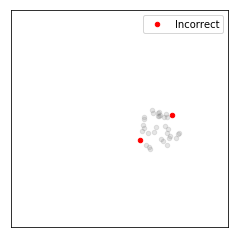

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


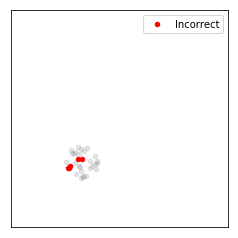

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.972473604826546,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9705882352941176,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/f1': 0.9743589743589743,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/acc_f1': 0.893125,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.90625,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/f1': 0.88}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


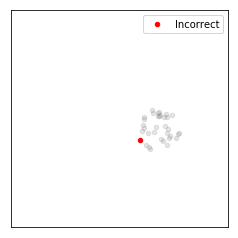

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


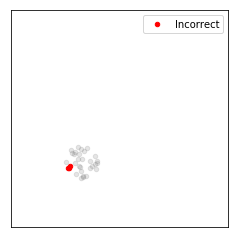

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9455882352941176,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9411764705882353,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/f1': 0.9500000000000001,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/acc_f1': 0.9302884615384615,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.9375,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/f1': 0.923076923076923}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


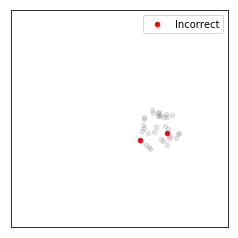

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


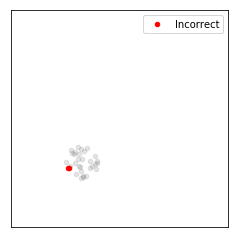

In [14]:
for model_name in model_configs.keys():
    if model_name == 'soft_param':
        labelcats_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",    
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind",
        }
    else:
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",        
        }

    eval_payload.remap_labelsets(labels_to_tasks, default_none=True)
    if model_name in ["hard_param", "soft_param", "manual_reweighting", "slice_qp_rep"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, None).
labelset 'labelset:slice_1:pred' -> task 'test_task' (originally, test_task:slice_1:pred).
labelset 'labelset:slice_2:pred' -> task 'test_task' (originally, test_task:slice_2:pred).
labelset 'labelset:remainder:pred' -> task 'test_task' (originally, None).
==========Evaluating slice_qp_rep==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9840131126889602,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9822635135135135,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9857627118644069,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.9442724458204335,
    'test_task/pay

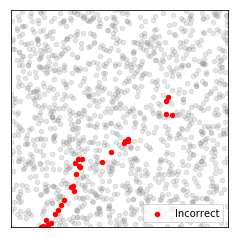

Vizualizing test_task predictions on labelset:slice_1:pred


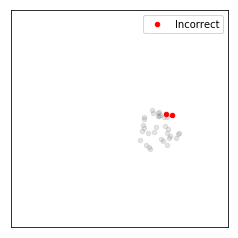

Vizualizing test_task predictions on labelset:slice_2:pred


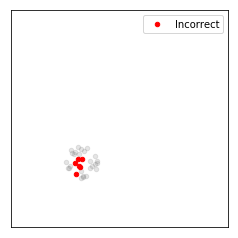

Vizualizing test_task predictions on labelset:remainder:pred


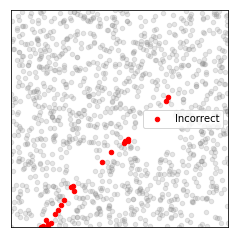

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9824905519926705,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9805743243243243,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9844067796610169,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.915341812400636,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task/payload_test/labelset:slice_1:pred/f1': 0.918918918918919,
    'test_task/payload_test/labelset:slice_2:pred/acc_f1': 0.8180147058823529,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.8125,
    'test_task/payload_test/labelset:sli

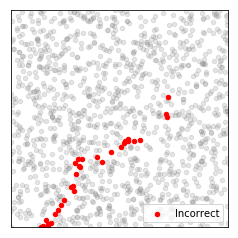

Vizualizing test_task predictions on labelset:slice_1:pred


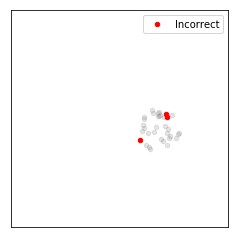

Vizualizing test_task predictions on labelset:slice_2:pred


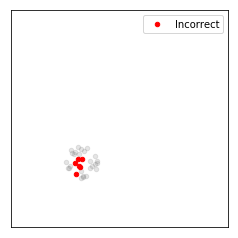

Vizualizing test_task predictions on labelset:remainder:pred


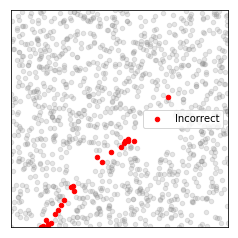

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9832669696083093,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.981418918918919,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9851150202976996,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.8856209150326797,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.8823529411764706,
    'test_task/payload_test/labelset:slice_1:pred/f1': 0.8888888888888888,
    'test_task/payload_test/labelset:slice_2:pred/acc_f1': 0.8180147058823529,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.8125,
    'test_task/payload_test/lab

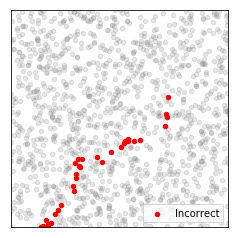

Vizualizing test_task predictions on labelset:slice_1:pred


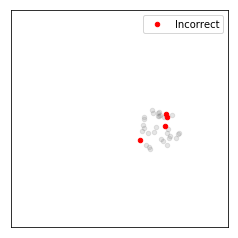

Vizualizing test_task predictions on labelset:slice_2:pred


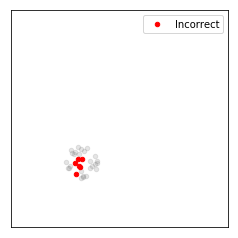

Vizualizing test_task predictions on labelset:remainder:pred


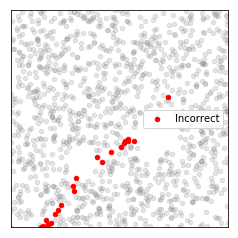

==========Evaluating moe==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9885738908460395,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.987331081081081,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.989816700610998,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 1.0,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 1.0,
    'test_task/payload_test/labelset:slice_1:pred/f1': 1.0,
    'test_task/payload_test/labelset:slice_2:pred/acc_f1': 0.8180147058823529,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.8125,
    'test_task/payload_test/labelset:slice_2:pred/f1': 0.8235294117647058,
    'test_task/pa

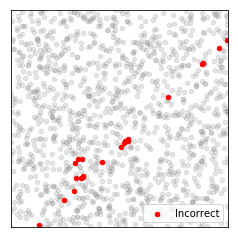

Vizualizing test_task predictions on labelset:slice_1:pred


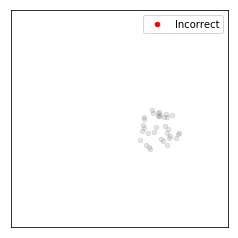

Vizualizing test_task predictions on labelset:slice_2:pred


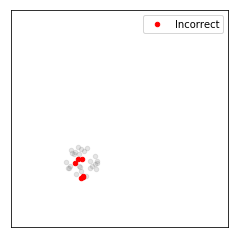

Vizualizing test_task predictions on labelset:remainder:pred


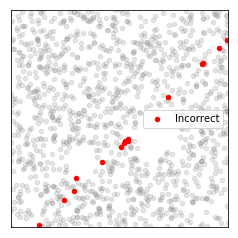

==========Evaluating naive==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9931401808844875,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9923986486486487,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9938817131203264,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.915341812400636,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task/payload_test/labelset:slice_1:pred/f1': 0.918918918918919,
    'test_task/payload_test/labelset:slice_2:pred/acc_f1': 0.9671336206896552,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.96875,
    'test_task/payload_test/labelset:slice_2

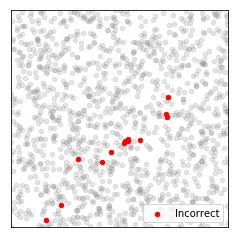

Vizualizing test_task predictions on labelset:slice_1:pred


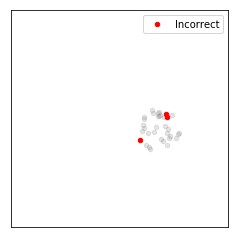

Vizualizing test_task predictions on labelset:slice_2:pred


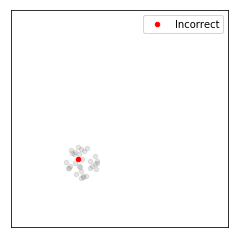

Vizualizing test_task predictions on labelset:remainder:pred


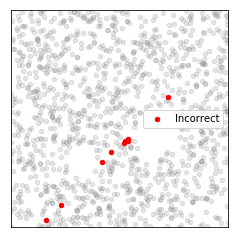

In [15]:
# map all labelsets to the primary task_head 
eval_payload.remap_labelsets(labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:slice_1:pred": "test_task",
        "labelset:slice_2:pred": "test_task",
        "labelset:remainder:pred": "test_task",
    }, default_none=True
                            
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

********** slice_qp_rep **********
labelset 'labelset:slice_1:ind' -> task 'test_task:slice_1:ind' (originally, None).
labelset 'labelset:slice_2:ind' -> task 'test_task:slice_2:ind' (originally, None).
Vizualizing test_task:BASE:ind attention on labelset_gold


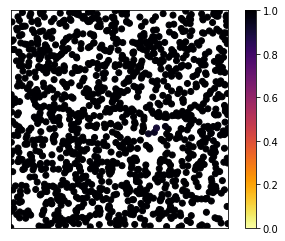

Vizualizing test_task:slice_1:ind attention on labelset_gold


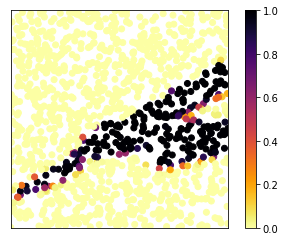

Vizualizing test_task:slice_2:ind attention on labelset_gold


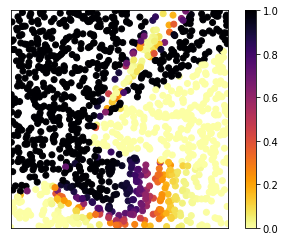

Vizualizing test_task:BASE:ind attention on labelset:slice_1:pred


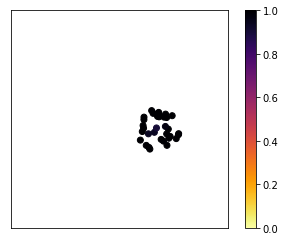

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:pred


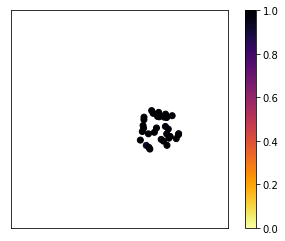

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:pred


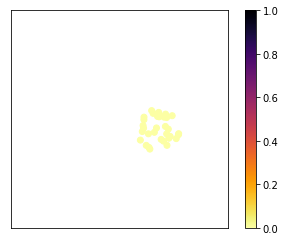

Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


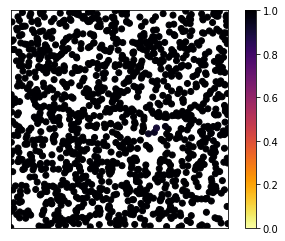

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


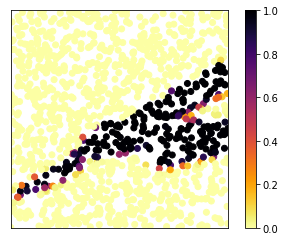

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


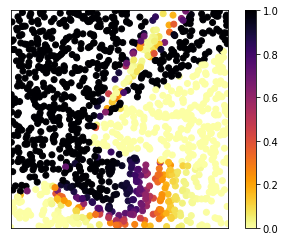

Vizualizing test_task:BASE:ind attention on labelset:slice_2:pred


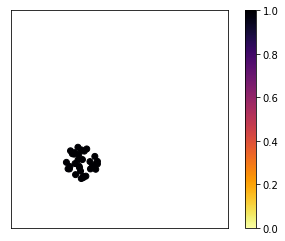

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:pred


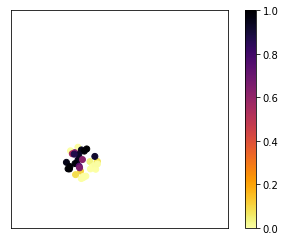

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:pred


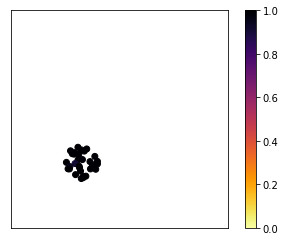

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


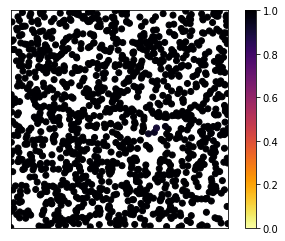

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


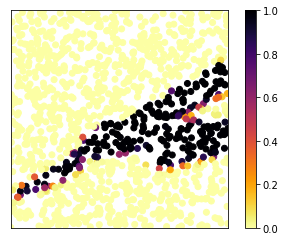

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


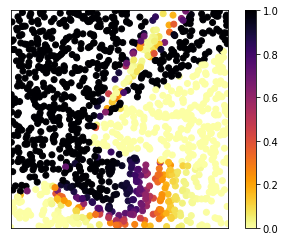

Vizualizing test_task:BASE:ind attention on labelset:remainder:pred


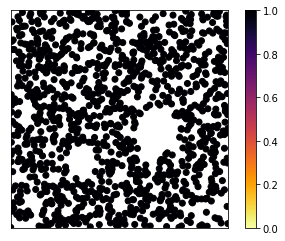

Vizualizing test_task:slice_1:ind attention on labelset:remainder:pred


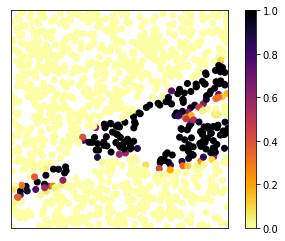

Vizualizing test_task:slice_2:ind attention on labelset:remainder:pred


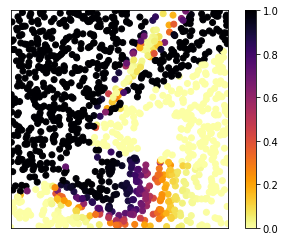

In [16]:
for model_name in trained_models.keys():
    if model_name not in ['soft_param', 'soft_param_rep', 'slice_qp_rep']:
        continue

    print(f'{"*"*10} {model_name} {"*"*10}')
    eval_payload.remap_labelsets(labels_to_tasks = {
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind"
        }
    )

    visualize_attention(trained_models[model_name], eval_payload)